In [145]:
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks,argrelextrema
from datetime import date
from numpy.polynomial.polynomial import polyval
d = date.isoformat(date.today())
v = 0

In [146]:
def format_func(value, tick_number):
    return("{:.2E}".format(value))
def hc_fin_func(hc,hc_opp,hc_sym):
    if hc_sym == 'sym':
        hc_fin = (hc + hc_opp)/2
    elif hc_sym == 'antisym':
        hc_fin = (hc - hc_opp)/2
    elif hc_sym == 'bare':
        hc_fin = hc
    return(hc_fin)
def col_type_func(m_theta,case):
        #CASE == 0: THETA1=-THETA2 = THETA_NC
        #CASE == 1: THETA1= 0, THETA2 = +/- THETA_NC
        #CASE == 2: THETA1= 0/THETA_NC, THETA2 = THETA_NC/0
        #IN DEGREES
    if case == 0:
        theta_nc = (m_theta[0] - m_theta[1])/2
        theta_col = (m_theta[0] + m_theta[1])/2
    elif case == 1:
        theta_nc = m_theta[0] - m_theta[1]
        theta_col = m_theta[0]
    elif case == 2:
        theta_nc = m_theta[0] - m_theta[1]
        theta_col = m_theta[0]
    return(theta_col,abs(180./np.pi*theta_nc))
def setup_check(keyword,prefix,fname):
    pattern = keyword + "\s*=\s*['a-z]+|" + keyword + "\s*=\s*(\d+(.\d*)+(.\d*)E\+\d\d)|" + keyword + "\s*=\s*"
    with open(prefix + fname + '/setup.cfg','r') as fin:
        for num,line in enumerate(fin,1):
            s = re.search(pattern,line)
            if s!=None:
                if s.group(2)!=None:
                    val = float(s.group(1))
    return(val)


In [147]:
datesets = ["20190423","20190424","20190425"]
prefixsold = ["/Users/kipp/STB/output_jureca/" + d + "/" for d in datesets]
prefixs = ["/Data/ias-1/kipp/" + d + "/" for d in datesets]
save_prefix = "/Users/kipp/STB/weyl_figures/Weyl_figures/"
coltypes = ['col','noncol']
func_col_types = [1,0,2]
hc_syms = ['sym','antisym']
findbool = False
key = 'anticol_theta'
rotation = 'scancol'
rotation2 = 'scancolflip'
seedfname = "path_rel_G-K-Kprime"
save_strs = ["datafrom_" + ds for ds in datesets]
inputname = seedfname + '_' + key + '_' + rotation
inputname2 = seedfname + '_' + key + '_' + rotation2
files = 51
j = 0
peakexp = 3
symdict = {'sym':0,'antisym':files//2}
symstringdict = {'sym': 'symmetric','antisym':'antisymmetric'}
colthetalabeldict = {'col':'$\Theta_{col}$ [deg.]','noncol':'$\Theta_{nc}$ [deg.]'}
coltypesdict = dict(list(zip(datesets,func_col_types)))
symhclabeldict = {'sym':r'$\sigma_{sym,xy}$ [$\frac{e^2}{h}$]','antisym':r'$\sigma_{asym,xy}$ [$\frac{e^2}{h}$]'}
labeldict = {'pwd':r"$\frac{\Delta\sigma}{\Delta\Theta}$",'peak':"$\sigma$"}

In [148]:
peakslist = np.zeros((files,peakexp),dtype = int)
angles = np.zeros(files,dtype = float)
def sigma_v_theta(dateset,inputname,inputname2,files,hc_sym,coltype):
    prefix = "/Data/ias-1/kipp/" + dateset + "/"
    hc_E = np.load(prefix + inputname + '_{:02}/'.format(symdict[hc_sym]) + 'hall_cond_E.npy')
    hc_default = np.load(prefix + inputname + '_{:02}/'.format(symdict[hc_sym]) + 'hall_cond.npy')
    hc_opp_default = np.load(prefix + inputname2 + '_{:02}/'.format(symdict[hc_sym]) + 'hall_cond.npy')
    hc_fin_default = hc_fin_func(hc_default,hc_opp_default,hc_sym)
    m_theta = 180./np.pi*np.load(prefix + inputname + '_{:02}/'.format(symdict[hc_sym]) + 'm_theta.npy')
    m_theta_opp = 180./np.pi*np.load(prefix + inputname2 + '_{:02}/'.format(symdict[hc_sym]) + 'm_theta.npy')
    '''if coltype == 'noncol':
        theta_diff = (m_theta-m_theta_opp)/2
    else:
        theta_diff = (m_theta+m_theta_opp)/2
    angles[symdict[hc_sym]] = theta_diff[0]'''
    theta_col,theta_nc = col_type_func(m_theta,coltypesdict[dateset])
    angles[symdict[hc_sym]] = theta_col
    npoints = hc_default.shape[0]
    index = npoints
    prom = abs(max(hc_fin_default)/4)
    peaks, props = find_peaks(abs(hc_fin_default[:index]), prominence = prom)#,distance = npoints/peakexp)
    relpeaks = np.sort(np.flip(peaks[np.argsort(abs(hc_fin_default[peaks]))]))
    numpeaks = peaks.shape[0]
    peakdist = (relpeaks[-1]-relpeaks[0])/(numpeaks-1)*0.9
    peakslist = np.tile(relpeaks,(files,1))
    peakvallist = np.tile(hc_fin_default[relpeaks],(files,1))
    for j in range(files):
        hc = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond.npy')
        hc_opp = np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'hall_cond.npy')
        hc_E = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond_E.npy')
        m_theta = 180./np.pi*np.load(prefix + inputname + '_{:02}/'.format(j) + 'm_theta.npy')
        m_theta_opp = 180./np.pi*np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'm_theta.npy')
        '''if coltype == 'noncol':
            theta_diff = (m_theta-m_theta_opp)/2
        else:
            theta_diff = (m_theta+m_theta_opp)/2
        angles[j] = theta_diff[0]'''
        theta_col,theta_nc = col_type_func(m_theta,coltypesdict[dateset])
        angles[j] = theta_col
        hc_fin = hc_fin_func(hc,hc_opp,hc_sym)
        peakvallist[j] = hc_fin[peakslist[j]]
        if findbool == True:
            npoints = hc.shape[0]
            index = npoints
            prom = abs(max(hc_fin)/4)
            peaks, props = find_peaks(abs(hc_fin[:index]), prominence = prom,distance = peakdist)#,width = 1)
            if peaks.shape[0]>=numpeaks:
                relpeaks = np.sort(np.flip(peaks[np.argsort(abs(hc_fin[peaks]))]))[:numpeaks]
            else:
                peakslist[j,:] = relpeaks
                peakvallist[j,:] = hc_fin[peakslist[j,:]]
    return(peakslist,peakvallist,angles)
            #JUST LEAVE IT WITH PEAKPOS FROM FIRST SET? THIS WOULD CORRESPOND TO FIXED ENERGY FOR EVERY SET
            #FABIANS IDEA: EXTRACT ENERGY FROM BANDSTRUCTURE (MIN MAX OF BANDS)

In [163]:
def sigma_v_theta_plotter(dateset,inputname,inputname2,save_prefix,save_str,hc_sym,coltype,peakslist,peakvallist,angles,fitdeg,fitlog=True):
    prefix = "/Data/ias-1/kipp/" + dateset + "/"
    j = symdict[hc_sym]
    start = files//2 - files//10 - 1
    stop = files//2 + files//10
    mfs = 20
    delta = 10**(-10)
    fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (3*6.4,2*4.8),constrained_layout = True,sharex = "row",sharey = 'row')
    hc_E = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond_E.npy')
    hc = np.load(prefix + inputname + '_{:02}/'.format(j) + 'hall_cond.npy')
    hc_opp = np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'hall_cond.npy')
    hc_fin = hc_fin_func(hc,hc_opp,hc_sym)
    fig.suptitle('Hall conductance ' + symstringdict[hc_sym] + ' part',fontsize = mfs)
    ax[0,0].plot(hc_E,hc_fin,'blue')
    ax[0,0].grid(True)
    ax[0,0].set_xlabel('Energy [eV]',fontsize = mfs)
    ax[0,0].set_ylabel(symhclabeldict[hc_sym],fontsize = mfs)
    ax[0,0].tick_params(labelsize = mfs)
    ax[0,0].set_title("$\Theta_{col} = $" + "{:1.2f}".format(angles[j]),fontsize = mfs)
    ax[0,1].set_axis_off()
    ax[0,2].remove()
    ax[1,0].set_ylabel(symhclabeldict[hc_sym],fontsize = mfs)
    ax[1,0].set_xlabel(colthetalabeldict[coltype],fontsize = mfs)
    
    axins = inset_axes(ax[0,1], width=2.6, height=1.8,loc = 'upper left')
    axins.tick_params(tick1On = False,labelleft=False, labelbottom=False)
    #axins.set_title('Spin Configuration')
    axins.set_xlim(-1.8,2.8)
    axins.set_ylim(-1.2,1.2)
    m_theta = np.load(prefix + inputname + '_{:02}/'.format(j) + 'm_theta.npy')
    m_theta_opp = np.load(prefix + inputname2 + '_{:02}/'.format(j) + 'm_theta.npy')
    theta_col,theta_nc = col_type_func(m_theta,coltypesdict[dateset])
    dx = np.sin(m_theta)
    dz = np.cos(m_theta)
    dx_opp = np.sin(m_theta_opp)
    dz_opp = np.cos(m_theta_opp)        
    axins.arrow(1.65, 0, dx[1],dz[1], head_width=0.1, head_length=0.1,color = 'blue')
    axins.arrow(-0.65, 0, dx[0],dz[0], head_width=0.1, head_length=0.1,color = 'blue')
    axins.arrow(1.65, 0, dx_opp[1],dz_opp[1], head_width=0.1, head_length=0.1,color = 'red')
    axins.arrow(-0.65, 0, dx_opp[0],dz_opp[0], head_width=0.1, head_length=0.1,color = 'red')
    ylims = ax[0,1].get_ylim()
    xlims = ax[0,1].get_xlim()
    for n in range(3):
        if fitlog == True:
            fitinx = angles[start:stop]
            fitiny = peakvallist[start:stop,n]
            p = np.polyfit(fitinx,fitiny,deg = fitdeg) 
            ax[1,n].plot(fitinx,yfit,'g',label = 'fit')
            yfit = polyval(fitinx,np.flip(p))
        hc_pwd = (peakvallist[:,n]-np.roll(peakvallist[:,n],1))/(angles[n]- np.roll(angles,1)[n])
        hc_pwd2 = (peakvallist[:,n]-np.roll(peakvallist[:,n],-1))/(angles[n]- np.roll(angles,-1)[n])
        hc_pwd = (hc_pwd+hc_pwd2)/2
        hc_pwd[[0,-1]] = hc_pwd[[1,-2]]
        ax[0,0].plot(hc_E[peakslist[j,n]],hc_fin[peakslist[j,n]],'bo')
        if hc_fin[peakslist[j,n]]<0:
            vaval = "bottom"
            textpos = (hc_E[peakslist[j,n]],hc_fin[peakslist[j,n]]+0.1*ylims[1])  
        elif hc_fin[peakslist[j,n]]>0:
            vaval = "top"            
            textpos = (hc_E[peakslist[j,n]],hc_fin[peakslist[j,n]]-0.1*ylims[1])  
        an = ax[0,0].annotate("E = {:1.2f} eV".format(hc_E[peakslist[j,n]]), xy=(0., 0.),
                              xytext=textpos, textcoords="data",
                              va=vaval, ha="center", fontsize = mfs-6,
                              bbox=dict(boxstyle="round", fc="w")
                             ) 
        ax[1,n].grid(True)
        ax[1,n].xaxis.set_major_locator(plt.MultipleLocator(30))
        ax[1,n].tick_params(labelsize = mfs)
        #ax[1,n].set_ylabel(symhclabeldict[hc_sym],fontsize = mfs)
        ax[1,n].plot(angles,peakvallist[:,n],'b',label = labeldict['peak'])
        ax[1,n].plot(angles,hc_pwd,'r',label = labeldict['pwd'])
        
        #ax[1,n].set_title(symhclabeldict[hc_sym] + " vs. " + colthetalabeldict[coltype] + " at $E = {:1.2f}$ eV".format(hc_E[peakslist[j,n]]))
        ax[1,n].set_title("$E = {:1.2f}$ eV".format(hc_E[peakslist[j,n]]),fontsize = mfs)
        ax[1,n].legend(loc = 'best',fontsize = mfs)
    lmda = setup_check('lambda',prefix,inputname + "_{:02}".format(j))
    t_so = setup_check('t_so',prefix,inputname + "_{:02}".format(j))
    temperature = setup_check('temperature',prefix,inputname + "_{:02}".format(j))
    thetastr = "$\Theta_{cant}$" + " = {0:1.2f} deg.".format(theta_nc)
    lambdastr = "$\lambda_{xc}$" + " = {0:1.2f}".format(lmda)
    t_sostr = "$t_{so}$" + " = {0:1.2f}".format(t_so)
    temperaturestr = "$temperature$" + " = {0:1.2f} K".format(temperature)
    textstr = thetastr + "\n" + temperaturestr + "\n" + lambdastr + "\n" + t_sostr
    ax[0,1].text(xlims[0], ylims[0], textstr,size = 18,
        horizontalalignment='left',
        verticalalignment='bottom')
'''
    if save_str == None:
        with PdfPages(save_prefix + d + '_' + str(v) + '_' + dateset + '_' + coltype + '_' + hc_sym + '_sigmatrend.pdf') as pdf:
            pdf.savefig(fig)
    else:
        with PdfPages(save_prefix + d + '_' + str(v) + '_' + save_str + '_' + coltype + '_' + hc_sym + '_sigmatrend.pdf') as pdf:
            pdf.savefig(fig)
    plt.close(fig)'''

"\n    if save_str == None:\n        with PdfPages(save_prefix + d + '_' + str(v) + '_' + dateset + '_' + coltype + '_' + hc_sym + '_sigmatrend.pdf') as pdf:\n            pdf.savefig(fig)\n    else:\n        with PdfPages(save_prefix + d + '_' + str(v) + '_' + save_str + '_' + coltype + '_' + hc_sym + '_sigmatrend.pdf') as pdf:\n            pdf.savefig(fig)\n    plt.close(fig)"

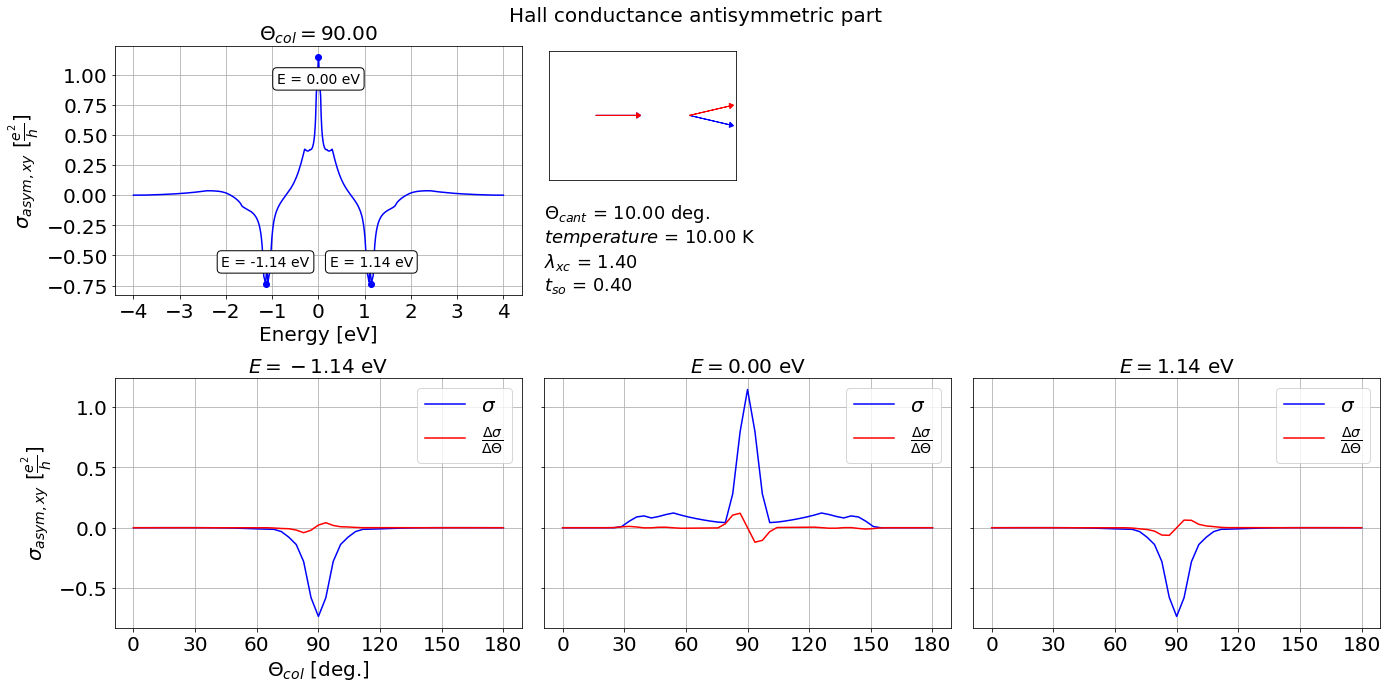

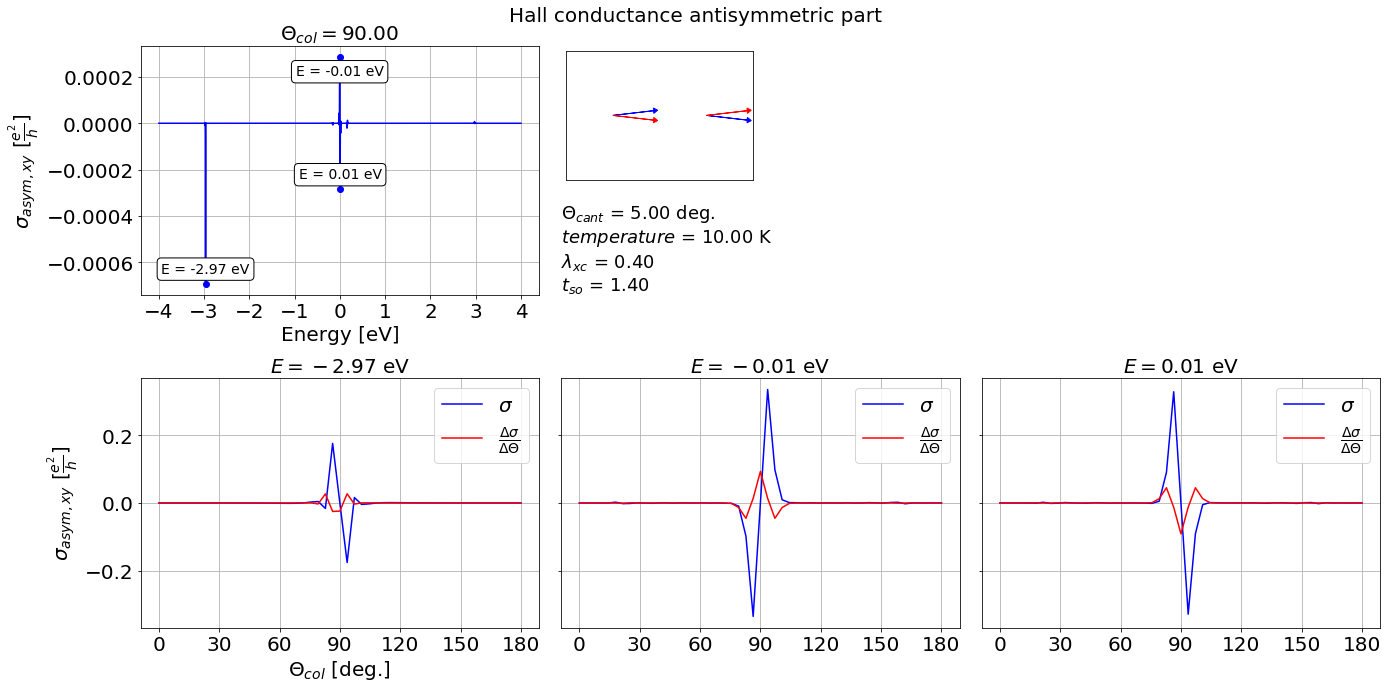

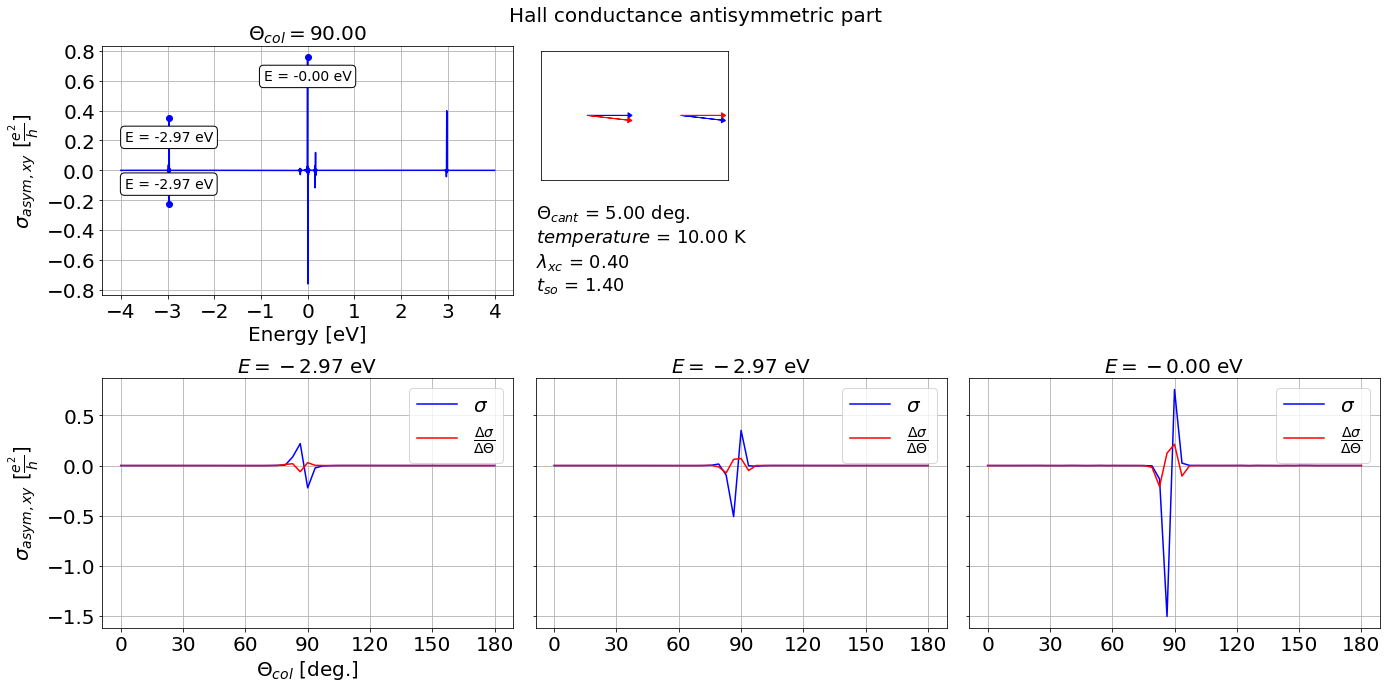

In [169]:
for j in [0,1,2]:
    peakslist,peakvallist,angles = sigma_v_theta(datesets[j],inputname,inputname2,files,hc_syms[1],coltypes[0])
    sigma_v_theta_plotter(datesets[j],inputname,inputname2,save_prefix,save_strs[j],hc_syms[1],coltypes[0],peakslist,peakvallist,angles,fitdeg = 2,fitlog = False)

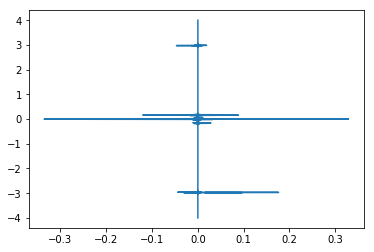

In [173]:
j = 24
k = 1
hc_E = np.load(prefixs[k] + inputname + '_{:02}/'.format(j) + 'hall_cond_E.npy')
hc = np.load(prefixs[k] + inputname + '_{:02}/'.format(j) + 'hall_cond.npy')
hc_opp = np.load(prefixs[k] + inputname2 + '_{:02}/'.format(j) + 'hall_cond.npy')
hc_fin = hc_fin_func(hc,hc_opp,hc_syms[1])
'''plt.plot(hc,hc_E)
plt.plot(hc_opp,hc_E)
'''
plt.plot(hc_fin,hc_E)

array([  2.50096078,   6.09913573,   9.70017547,  13.30121521,
        16.89939017,  20.50042991,  24.10146965,  27.69964461,
        31.30068435,  34.90172409,  38.49989904,  42.10093879,
        45.69911374,  49.30015348,  52.89832844,  56.49936818,
        60.10040792,  63.69858287,  67.29962262,  70.90066236,
        74.49883731,  78.09987705,  81.7009168 ,  85.29909175,
        88.90013149,  92.50117123,  96.09934619,  99.70038593,
       103.30142567, 106.89960063, 110.50064037, 114.10168011,
       117.69985506, 121.30089481, 124.89906976, 128.5001095 ,
       132.09828446, 135.6993242 , 139.30036394, 142.89853889,
       146.49957864, 150.10061838, 153.69879333, 157.29983308,
       160.90087282, 164.49904777, 168.10008751, 171.70112726,
       175.29930221, 178.90034195, 182.50138169])

In [143]:
for j in [0,1,2]:
    m_theta = np.load(prefixs[j] + inputname + '_{:02}/'.format(0) + 'm_theta.npy')
    print(m_theta)

[0.     0.1745]
[-0.0873  0.0873]
[0.     0.0873]


In [142]:
m_theta

array([0.    , 0.0873])